In [4]:
import cv2
import numpy as np
import os
from plt_utils import plt_imgshow

In [2]:
BOW_NUM_TRAINING_SAMPLES_PER_CLASS = 10
SVM_NUM_TRAINING_SAMPLES_PER_CLASS = 110

BOW_NUM_CLUSTERS = 40

sift = cv2.SIFT_create()

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

bow_kmeans_trainer = cv2.BOWKMeansTrainer(BOW_NUM_CLUSTERS)
bow_extractor = cv2.BOWImgDescriptorExtractor(sift, flann)

def get_pos_and_neg_paths(i):
    pos_path = 'CarData/TrainImages/pos-%d.pgm' % (i+1)
    neg_path = 'CarData/TrainImages/neg-%d.pgm' % (i+1)
    return pos_path, neg_path

def add_sample(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = sift.detectAndCompute(img, None)
    if descriptors is not None:
        bow_kmeans_trainer.add(descriptors)

for i in range(BOW_NUM_TRAINING_SAMPLES_PER_CLASS):
    pos_path, neg_path = get_pos_and_neg_paths(i)
    add_sample(pos_path)
    add_sample(neg_path)

voc = bow_kmeans_trainer.cluster()
bow_extractor.setVocabulary(voc)

def extract_bow_descriptors(img):
    features = sift.detect(img)
    return bow_extractor.compute(img, features)

training_data = []
training_labels = []
for i in range(SVM_NUM_TRAINING_SAMPLES_PER_CLASS):
    pos_path, neg_path = get_pos_and_neg_paths(i)
    pos_img = cv2.imread(pos_path, cv2.IMREAD_GRAYSCALE)
    pos_descriptors = extract_bow_descriptors(pos_img)
    if pos_descriptors is not None:
        training_data.extend(pos_descriptors)
        training_labels.append(1)
    neg_img = cv2.imread(neg_path, cv2.IMREAD_GRAYSCALE)
    neg_descriptors = extract_bow_descriptors(neg_img)
    if neg_descriptors is not None:
        training_data.extend(neg_descriptors)
        training_labels.append(-1)

svm = cv2.ml.SVM_create()

svm.train(np.array(training_data), cv2.ml.ROW_SAMPLE,
          np.array(training_labels))

True

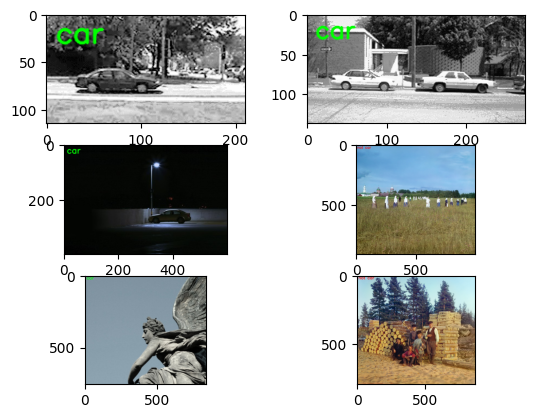

In [8]:
imgs = []
for test_img_path in ['CarData/TestImages/test-0.pgm',
                      'CarData/TestImages/test-1.pgm',
                      '../images/car.jpg',
                      '../images/haying.jpg',
                      '../images/statue.jpg',
                      '../images/woodcutters.jpg']:
    img = cv2.imread(test_img_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    descriptors = extract_bow_descriptors(gray_img)
    prediction = svm.predict(descriptors)
    if prediction[1][0][0] == 1.0:
        text = 'car'
        color = (0, 255, 0)
    else:
        text = 'not car'
        color = (0, 0, 255)
    cv2.putText(img, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1,
                color, 2, cv2.LINE_AA)
    imgs.append(img)
plt_imgshow(imgs,columns=2)